Control of a Predator-Prey System : Zuhair Lateef
===

In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from sympy import *
from control import *
from scipy.integrate import odeint
%matplotlib inline
init_printing(use_latex='mathjax')

# The System

For this project you will control a system consisting of a chemostat
of well-mixed nutrients and two types of microscopic organisms: algae
and rotifers (Fig.  \ref{fig:chemostat}).  The
concentration of nutrients in the system as a function of time is
$n(t)$ micromoles per microliter. The concentrations of algae and
rotifers in the system are $a(t)$ and $b(t)$ cells per microliter
respectively. The control input is the rate $u(t)$ at which nutrients
are added to the system. The output $y(t)$ of the system is the
concentration $b(t)$ of predator cells in the system. The rotifers
have been genetically engineered to express a protein called green
fluorescent protein (GFP) (usually found in jellyfish), which
can be measured continuously with a spectrofluorimeter.

<img width=35% src="https://raw.githubusercontent.com/klavins/ECE447/master/images/chemostat.png">

A model of the dynamics of this system is as follows. Nutrients are
added to the system at a rate $u$ and are digested by algae at a rate
proportional to the concentration of nutrients times the concentration
of algae. Symbolically,

$$
\dot n = u - k_1 n a, 
$$

where $k_1 > 0$ is the rate of digestion. Algae reproduce at a rate
proportional to the rate of nutrient digestion. However, the algae are
eaten by rotifers at rate proportional to the product of their
concentrations. Also, the algae die at a certain rate as well. In
symbols,

$$
\dot a = k_1 \alpha n a - k_2 a b - k_3 a,
$$

where $\alpha > 0$, $k_2 > 0$ and $k_3 > 0$. Finally, the rotifers
reproduce at a rate proportional to the rate ate which they eat algae,
and they die because their genetic alterations make the nutrient
poisonous to them.

$$
\dot b = k_2 \beta a b - k_4 n b.
$$

Finally, as was described above, the output is

$$
y = b.
$$

Suppose the parameters have been measured and found to be
approximately

\begin{eqnarray*}
k_1 & = & 0.5 \\
k_2 & = & 0.7 \\
k_3 & = & 0.5 \\
k_4 & = & 0.9 \\
\alpha & = & 1.1 \\
\beta & = & 2.0 .
\end{eqnarray*}

Note: all rates are measured in reactions per hour. 

# Task 1: Simulation

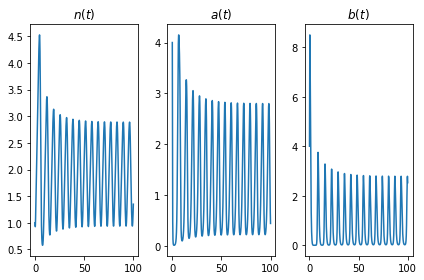

In [2]:
#parameters
k1 = .5
k2 = .7
k3 = .5
k4 = .9
alpha = 1.1
beta = 2.0
u = 1

#Puts differential equations into matrix form
def sim(x,t):
    n,a,b = x
    dxdt = [u - k1*n*a, k1*alpha*a*n - k2*a*b - k3*a, k2*beta*a*b - k4*n*b]
    return dxdt

#Arbitrary starting point to visualize system behavior
x0 = [1, 4, 4]
t = np.arange(0,100,.01)
sol = odeint(sim, x0, t)
plt.subplot(1,3,1)
plt.plot(t,sol[:,0]);
plt.title("$n(t)$");
plt.subplot(1,3,2)
plt.plot(t,sol[:,1]);
plt.title("$a(t)$");
plt.subplot(1,3,3)
plt.plot(t,sol[:,2]);
plt.title("$b(t)$");
plt.tight_layout()

# Task 2: Performance Specification

Our system will be stable when the final value of $b(t)=1$ with a settling time of less than 5 hours or $t<5$. This is because the we want to prevent the rapid evolution of the algae since they evolve to defend themselves when the rotifer population is high. We also want to minimize percent overshoot as much as possible. For this problem will use $P.O. = 10$%. This value is subject to change if our control methods are unable to produce such a value.

# Task 3: Linearization

If system is at equilibrium, $\dot n = \dot a = \dot b = 0$

We know $b = 1$, so we can solve for $n^*$, $a^*$, and $u^*$ by using a system of equations.

In [3]:
#Create variables
var("n,a,u")
b = 1
bstar = b

#Differential equations
dn = u - k1*n*a
da = k1*alpha*a*n - k2*a*bstar - k3*a
db = k2*beta*a*bstar - k4*n*bstar

#Solve system of equations
n1 = solve(db,n)
da = da.subs(n,n1[0])
astar = solve(da,a)[1]
nstar = n1[0].subs(a,astar)
dn = dn.subs([(a,astar),(n,nstar)])
ustar = solve(dn,u)[0]

#Equilibrium point
astar,nstar,ustar

(1.4025974025974, 2.18181818181818, 1.53010625737898)

In [4]:
#Create State Space Representation
var("b,u")
dn = u - k1*n*a
da = k1*alpha*a*n - k2*a*b - k3*a
db = k2*beta*a*b - k4*n*b
A = Matrix([[diff(dn,n),diff(dn,a),diff(dn,b)],
            [diff(da,n),diff(da,a),diff(da,b)],
            [diff(db,n),diff(db,a),diff(db,b)]])
A = A.subs([(n,nstar),(a,astar),(b,bstar)])
B = Matrix([[ustar],[0],[0]])
C = Matrix([[0,0,1]])
A,B,C

⎛⎡-0.701298701298701   -1.09090909090909              0          ⎤  ⎡1.5301062
⎜⎢                                                               ⎥  ⎢         
⎜⎢0.771428571428571   2.22044604925031e-16   -0.981818181818182  ⎥, ⎢       0 
⎜⎢                                                               ⎥  ⎢         
⎝⎣       -0.9                 1.4           -2.22044604925031e-16⎦  ⎣       0 

5737898⎤           ⎞
       ⎥           ⎟
       ⎥, [0  0  1]⎟
       ⎥           ⎟
       ⎦           ⎠

In [5]:
#Create Transfer Function
var("s")

#Convert to usable format
An = np.array(A).astype(np.float64)
Bn = np.array(B).astype(np.float64)
Cn = np.array(C).astype(np.float64)

#Use equation for transfer functions and plug in values
T = (Cn*(s*eye(3)-An).inv()*Bn)[0]
T = cancel(T)
T

                  -1.0⋅(1.06233091583741⋅s - 1.27479709900489)                
──────────────────────────────────────────────────────────────────────────────
                   3                     2                                    
0.771428571428571⋅s  + 0.54100185528757⋅s  + 1.70956586270872⋅s + 1.4872632821

    
────
    
7237

In [6]:
#Solve denominator of transfer function to find poles
num1,den1 = fraction(T)
poles = solve(den1,s)
poles

[-0.829969642040104, 0.064335470370701 - 1.52274680035263⋅ⅈ, 0.064335470370701
 + 1.52274680035263⋅ⅈ]

One pole is real and the other two are complex. The real pole is negative which infers stability. The complex poles have positive real parts, which infers oscillation and instability. Based on these poles, we can expect the system to oscillate in an unstable manner by growing to infinity.

# Task 4: Root Locus Design

**a)**

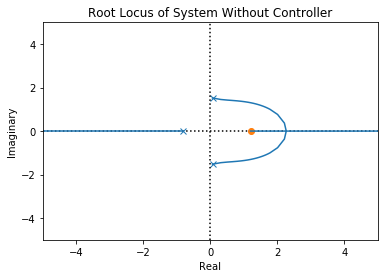

In [7]:
#Convert to usable format
num1 = np.array(Poly(num1).coeffs()).astype(np.float64)
den1 = np.array(Poly(den1).coeffs()).astype(np.float64)

#Find transfer function and plot root locus
sysT = tf(num1,den1)
plot = root_locus(sysT,xlim=(-5,5),ylim=(-5,5))
plt.title("Root Locus of System Without Controller");

In [8]:
#Find values of zeta and omega to create characteristic polynomial
var("zeta omega")

#Using a settling time of 3 hours and a Percent Overshoot of 10%
sol=solve([(4/(zeta*omega))-4, exp(-zeta*pi/sqrt(1-zeta**2))-0.1])[0]
sol

{ω: 1.69160362819508, ζ: 0.591155033798898}

In [9]:
#Design and implement controller. Then find transfer function of controlled system
den = (s**2 + 2*zeta*omega*s + omega**2).subs(sol)
Gc = -den
Tfeedback = T*Gc
num, den = fraction(Tfeedback)
Tfeedback = Tfeedback.cancel()
Tfeedback

    ⎛                  3                      2                               
1.0⋅⎝1.06233091583741⋅s  + 0.849864732669924⋅s  + 0.490289975903368⋅s - 3.6478
──────────────────────────────────────────────────────────────────────────────
                       3                     2                                
    0.771428571428571⋅s  + 0.54100185528757⋅s  + 1.70956586270872⋅s + 1.487263

          ⎞
6100869577⎠
───────────
           
28217237   

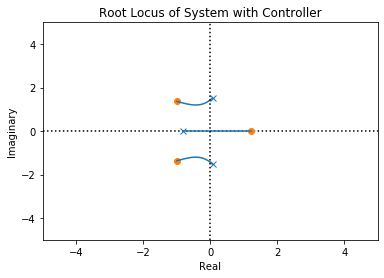

In [10]:
num, den = fraction(Tfeedback)

#Convert to usable format
num = np.array(Poly(num).coeffs()).astype(np.float64)
den = np.array(Poly(den).coeffs()).astype(np.float64)

#Create transfer function and plot new root locus
sys = tf(num,den)
plot = root_locus(sys,xlim=(-5,5),ylim=(-5,5));
plt.title("Root Locus of System with Controller");

**b)**

Linear:

C:\Users\zuhai\Anaconda3\lib\site-packages\control\timeresp.py:703: UserWarning: System has direct feedthrough: ``D != 0``. The infinite impulse at ``t=0`` does not appear in the output. 
Results may be meaningless!
  warnings.warn('System has direct feedthrough: ``D != 0``. The infinite '


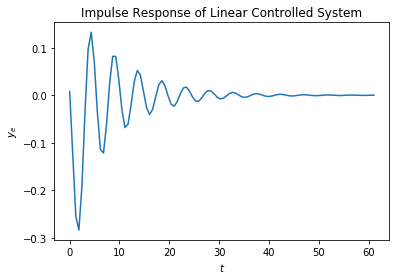

In [11]:
var("K")
polyno = (s**2 + 2*zeta*omega*s + omega**2).subs(sol)
Gc = -polyno
Topen = K*Gc*T
Topen = Topen.cancel()
Topen = Topen.subs(K,.09)
Tclosed = Topen / (1+Topen)
Tfeedback = Tclosed.simplify()
numf, denf = fraction(Tfeedback)
numf = np.array(Poly(numf).coeffs()).astype(np.float64)
denf = np.array(Poly(denf).coeffs()).astype(np.float64)
sys3 = tf(numf,denf)
t,y = impulse_response(feedback(sys3))
plt.plot(t,y);
plt.title("Impulse Response of Linear Controlled System");
plt.xlabel("$t$");
plt.ylabel("$y_e$");

Nonlinear:

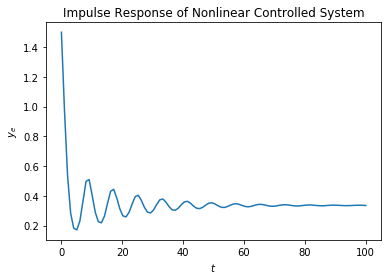

In [12]:
var("n,a,b,u")
dn = u - k1*n*a
da = k1*alpha*a*n - k2*a*b - k3*a
db = k2*beta*a*b - k4*n*b

def ImpIn(t):
    if t==0:
        return 1
    else:
        return 0

# Simulate the system
ldn = lambdify([n,a,b,u], dn)
lda = lambdify([n,a,b], da)
ldb = lambdify([n,a,b], db)

X0 = [2,1,1.5]
tn = np.linspace(0,100,100)

# Control law
def voltage(n,a,b):
    K = 0.09
    ne = nstar - n 
    ae = astar - a
    be = bstar - b 
    return ustar * K * (be + 2*ae + 2.861*ne)

# ODE right hand side
def f(X,t):
    n,a,b = X
    u = voltage(n,a,b)
    return [
        ldn(n,a,b,u),
        lda(n,a,b),
        ldb(n,a,b),
    ]

# Simulate
tn = np.linspace(0,100,100)
X = spi.odeint(f,X0,tn)
plt.plot(tn,X[:,2]);
plt.ylabel("$y_e$")
plt.xlabel("$t$")
plt.title("Impulse Response of Nonlinear Controlled System");

While the Root Locus method was successful for designing a controller, a controller that meets our percent overshoot and settling time specifications could not be created. This is because the system is too dynamic to be controlled with a single gain. We see this because moving the process of moving the imaginary poles towards the zeros (by tuning the gain) also moves the other pole closer to an unstable point, putting a limitation on our ability to control. Full state feedback should be much more successful in reaching our specifications.

The difference between the linear and nonlinear model is that the linear model is an approximation around an equilibrium point that uses derivatives to understand the behavior very close to that point. If the linear model is used for characterization far from that equilibrium point, it will likely be innaccurate due to incorrect extrapolation. We use the linear model in order to make computer modeling easier.

# Task 5:  Disturbances and Noise

**a)**

The disturbance would reduce the number of nutrients going into the system, which would increase the value of $y_e$. The controller may or may not work considering that it was not designed to deal with a disturbance. We can use a step input for the distrubance where $D(s)=\frac{-.01}{s}$ to show this.

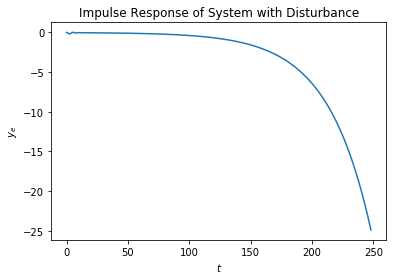

In [13]:
D = -.01/s
Gc = -polyno
Topen = (K*Gc+D)*T
Topen = Topen.cancel()
Topen = Topen.subs(K,.09)
Tclosed = Topen / (1+Topen)
Tfeedback = Tclosed.simplify()
numf, denf = fraction(Tfeedback)
numf = np.array(Poly(numf).coeffs()).astype(np.float64)
denf = np.array(Poly(denf).coeffs()).astype(np.float64)
sys3 = tf(numf,denf)
t,y = impulse_response(feedback(sys3))
plt.plot(t,y);
plt.title("Impulse Response of System with Disturbance");
plt.xlabel("$t$");
plt.ylabel("$y_e$");

**b)**

The controlled system highly sensitive to $\gamma$. This is proven in the calculation below where the sensitivity is 1. $\gamma$ changes our percieved value for the number of rotifers in the system may be some proportion less than it actually is, causing our controller to overcompensate. This would result in our system reaching the wrong equilibrium or possibly becoming unstable.

In [14]:
gamma = symbols("\gamma")
Cg = Matrix([[0,0,gamma]])
Tg = (Cg*(s*eye(3)-An).inv()*Bn)[0]
Topeng = K*Gc*Tg
Topeng = Topeng.cancel()
Topeng = Topeng.subs(K,.09)
Tclosedg = Topeng / (1+Topeng)
Tfeedbackg = Tclosed.simplify()
Sensitivity = diff(Tfeedbackg*gamma/Tfeedbackg)
Sensitivity.cancel()

1

# Task 6: Full State Feedback

Determine whether the system is controllable. If it is,
design a full state feedback controller to obtain the desired
performance. Plot the impulse response of the controlled system
with the linear model and the nonlinear model.

In [15]:
def MatrixFromColumns(clist):
    return Matrix(clist).reshape(
        clist[0].shape[0], 
        len(clist)).transpose()

M = MatrixFromColumns([B,A*B,A*A*B])
M, M.rank()

⎛⎡1.53010625737898  -1.0730615311489   -0.535137179170358⎤   ⎞
⎜⎢                                                       ⎥   ⎟
⎜⎢       0          1.18036768426378    0.52426720521846 ⎥, 3⎟
⎜⎢                                                       ⎥   ⎟
⎝⎣       0          -1.37709563164108   2.6182701360033  ⎦   ⎠

Since the rank of M is 3, the system is controllable.

In [16]:
#Find characteristic polynomial
desired_charpoly = ((s+10)*(s**2 + 2*zeta*omega*s + omega**2)).subs(sol)
desired_charpoly = desired_charpoly.expand()
desired_charpoly

 3         2                                        
s  + 12.0⋅s  + 22.8615228349228⋅s + 28.6152283492276

In [17]:
solve(desired_charpoly,s)

[-9.99999999999999, -1.0 - 1.36437635384184⋅ⅈ, -1.0 + 1.36437635384184⋅ⅈ]

In [18]:
#Plug in values to find needed gains
polydes = np.array(Poly(desired_charpoly).coeffs()).astype(np.float64)
k0,k1,k2 = symbols("k_0 k_1 k_2")
K = Matrix([[k0,k1,k2]])
charpoly = (s*eye(3)-(A-B*K)).det()
c1 = Poly(desired_charpoly,s).coeffs()
c2 = Poly(charpoly,s).coeffs()
#Solve for gains
gains = solve(Matrix(c1)-Matrix(c2),[k0,k1,k2])
Kvals = K.subs(gains)
Kvals

[7.38425925925928  12.978593063981  -3.86749255208866]

Linear:

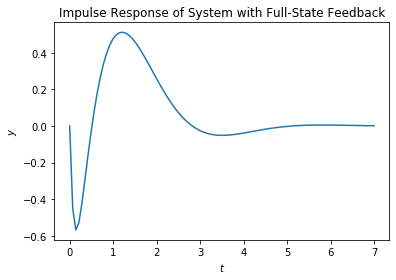

In [19]:
#Create state space representation
Astate = An - Bn*Kvals
Bstate = Bn * Kvals[0]
Cstate = Cn
Astate = np.array(Astate).astype(np.float64)
Bstate = np.array(Bstate).astype(np.float64)
Cstate = np.array(Cstate).astype(np.float64)

#Create transfer function from state space representation
Tstate = (Cstate*(s*eye(3)-Astate).inv()*Bstate)[0]
Tstate = cancel(Tstate)

#Plot impulse response of system
nums, dens = fraction(Tstate)
nums = np.array(Poly(nums).coeffs()).astype(np.float64)
dens = np.array(Poly(dens).coeffs()).astype(np.float64)
syss = tf(nums,dens)
ts,ys = impulse_response(syss)
plt.plot(ts,ys);
plt.xlabel("$t$")
plt.ylabel("$y$")
plt.title("Impulse Response of System with Full-State Feedback");

# Task 7: Observer Design

a) Unfortunately, it is not easy to measure the population of algae or
the concentration of nutrients. Determine whether the system is observable. If it is,
design an observer for the system. Explain your choice of observer gains.

b) Build a simulation of the system using your full state
controller and the observer. Plot the impulse response using the
linear and the nonlinear model. Assume that the concentration of
nutrients is initially $n(0)=0$. Plot the estimates of the other
states as well.

**a)**

In [20]:
O = Matrix([C,C*A,C*A**2])
O, O.rank()

⎛⎡       0                  0                    1          ⎤   ⎞
⎜⎢                                                          ⎥   ⎟
⎜⎢      -0.9               1.4         -2.22044604925031e-16⎥, 3⎟
⎜⎢                                                          ⎥   ⎟
⎝⎣1.71116883116883  0.981818181818182    -1.37454545454545  ⎦   ⎠

Since the matrix O has full rank (rank 3), the system is observable.

In [21]:
L = place(Astate.transpose(),Cstate.transpose(),[-5,-6,-7])
L

array([[-9.36297968,  2.65128246,  6.        ]])

**b)**

Linear:

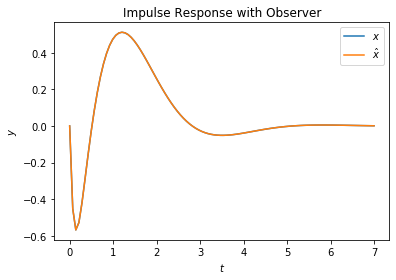

In [22]:
L = Matrix([[-9.3629],[2.651],[6]])
An = Matrix([[A,-B*Kvals],[L*C,A-B*Kvals-L*C]])
Bn = Matrix([[B],[B]])
Cn = Matrix([[C,0,0,0]])
An = Matrix([[-0.701298701298701,-1.09090909090909,0,-11.2987012987013,-19.8586264591727,5.91767455431746],
            [0.771428571428571,0,0.981818181818182,0,0,0],
            [-.9,1.4,0,0,0,0],
            [0,0,-9.3629,-12.0,-20.9495355500818,15.2805745543175],
            [0,0,2.651,0.771428571428571,0,3.63281818181818],
            [0,0,6,-.9,1.4,-6],])
Bn = Matrix([[1.53010625737898],[0],[0],[1.53010625737898],[0],[0]])
Cn = Matrix([[0,0,1,0,0,0]])
Ao = np.array(An).astype(np.float64)
Bo = np.array(Bn).astype(np.float64)
Co = np.array(Cn).astype(np.float64)
To = (Co*(s*eye(6)-Ao).inv()*Bo)[0]
To = cancel(To)
nums, dens = fraction(Tstate)
nums = np.array(Poly(nums).coeffs()).astype(np.float64)
dens = np.array(Poly(dens).coeffs()).astype(np.float64)
syss = tf(nums,dens)
t,y = impulse_response(syss)
plt.plot(ts,ys)
plt.plot(t,y);
plt.xlabel("$t$");
plt.ylabel("$y$");
plt.title("Impulse Response with Observer");
plt.legend(["$x$","$\hat{x}$"]);

Nonlinear:

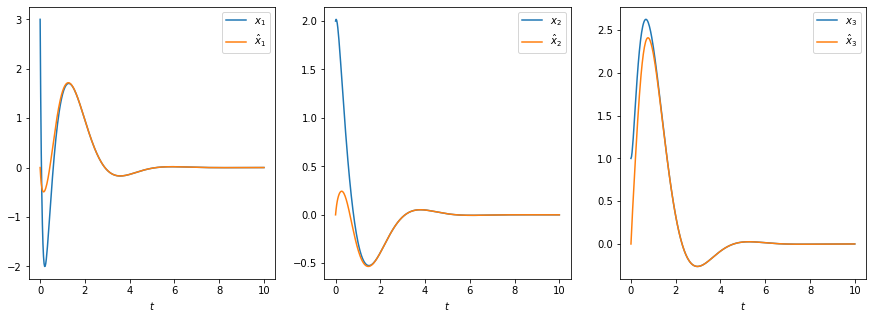

In [23]:
def f(X,t):
    x = Matrix([X[:3]]).transpose()
    xhat = Matrix([X[3:6]]).transpose()
    u = ImpIn(t)
    fb = L*(Cstate*x - Cstate*xhat)
    return flatten(
        (Astate*x + Bstate*u).tolist() + 
        (Astate*xhat + Bstate*u + fb).tolist())

t=np.linspace(0,10,400)
X = spi.odeint(f,[3,2,1,0,0,0],t)
fig,ax = plt.subplots(1,3,figsize=(15,5))

for i in range(3):
    ax[i].plot(t,X[:,i],label="$x_%d$" % (i+1))
    ax[i].plot(t,X[:,3+i],label="$\hat{x}_%d$" % (i+1));
    ax[i].set_xlabel("$t$")
    ax[i].legend()